### Load dependencies

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  

import netCDF4
from netCDF4 import Dataset, num2date, date2index
from datetime import datetime, timedelta

import time as tm
import numpy as np
from numpy import argmin, linspace, size, array

import cdo
from cdo import *
cdo = Cdo()

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.path as mpath

import cartopy as cp
import cartopy.feature as cfeature
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker

from shapely import geometry
from collections import namedtuple
from shapely.geometry.polygon import LinearRing

import matplotlib.patches as mpatches

import numpy.ma as ma
import pandas as pd
 
import matplotlib.cm as cm
import xarray as xr

### North Atlantic

Observational Data

In [2]:
observations=['lsce','csir','spco2','jena','jma','nies','ens']
f_ens = xr.open_dataset('/work/uo1075/from_Mistral/uo1075/u301331/observations/ens_1990-2020_co2.nc')
f_ens_time = f_ens.time

variability=np.zeros((8,5))

for i in range(0,len(observations)):
    f = '{}{}{}'.format('/work/uo1075/from_Mistral/uo1075/u301331/observations/',observations[i],'_1990-2020_co2.nc')
    # print(f)
    f1 = xr.open_dataset(f, decode_times=False)
    if (i == 3):
        f1= f1.rename({'mtime': 'time'})
    f1['time'] = f_ens_time
    
    f2 = f1.co2flux.sel(lon=slice(-90,-10),lat=slice(15,65)).sel(time=slice('1990','2019')).where(((f1.lat<50) + (f1.lon>-60)),drop=True)
    variability[i,0] =((f2.groupby('time.year').mean('time')).sum(('lon','lat')).std().values.round(3))
    variability[i,1] =(f2.sel(time=f2.time.dt.season=="DJF").groupby('time.year').mean('time').sum(('lon','lat')).std().values.round(3))
    variability[i,2] =(f2.sel(time=f2.time.dt.season=="MAM").groupby('time.year').mean('time').sum(('lon','lat')).std().values.round(3))
    variability[i,3] =(f2.sel(time=f2.time.dt.season=="JJA").groupby('time.year').mean('time').sum(('lon','lat')).std().values.round(3))
    variability[i,4] =(f2.sel(time=f2.time.dt.season=="SON").groupby('time.year').mean('time').sum(('lon','lat')).std().values.round(3))
    
f1 = xr.open_dataset('/work/uo1075/from_Mistral/uo1075/u301331/observations/mpi_1990-2020_co2.nc', decode_times=False)
f1['time'] = f_ens_time

f2 = f1.co2flux.sel(depth=0).sel(lon=slice(271,350),lat=slice(15,65)).where(((f1.lat<50) + (f1.lon>300)),drop=True).sel(time=slice('1990','2019'))
variability[7,0] =((f2.groupby('time.year').mean('time')).sum(('lon','lat')).std().values.round(3))
variability[7,1] =(f2.sel(time=f2.time.dt.season=="DJF").groupby('time.year').mean('time').sum(('lon','lat')).std().values.round(3))
variability[7,2] =(f2.sel(time=f2.time.dt.season=="MAM").groupby('time.year').mean('time').sum(('lon','lat')).std().values.round(3))
variability[7,3] =(f2.sel(time=f2.time.dt.season=="JJA").groupby('time.year').mean('time').sum(('lon','lat')).std().values.round(3))
variability[7,4] =(f2.sel(time=f2.time.dt.season=="SON").groupby('time.year').mean('time').sum(('lon','lat')).std().values.round(3))

# Make DataFrame
annual_ob=[]
winter_ob=[]
spring_ob=[]
summer_ob=[]
autumn_ob=[]

for i in range(0,7):
    annual_ob.append(variability[i][0])
    winter_ob.append(variability[i][1])
    spring_ob.append(variability[i][2])
    summer_ob.append(variability[i][3])
    autumn_ob.append(variability[i][4])
    
observations=pd.DataFrame(list(zip(annual_ob, winter_ob, spring_ob, summer_ob, autumn_ob)),
                     columns =['Annual Mean', 'Winter', 'Spring', 'Summer','Autumn'])

Model Data

In [3]:
variability_ge=np.zeros((100,5))
for i in range(1,101):
    f='{}{}{}'.format('/work/uo1075/from_Mistral/uo1075/u301331/model_GE_co2/GE_co2_',i,'.nc')
    # print(f)
    f1 = xr.open_dataset(f)
    
    f2 = f1.co2flux.sel(depth=0).sel(lon=slice(271,350),lat=slice(15,65)).where(((f1.lat<50) + (f1.lon>300)),drop=True).sel(time=slice('1990','2019'))
    variability_ge[i-1,0] =((f2.groupby('time.year').mean('time')).sum(('lon','lat')).std().values.round(3))
    variability_ge[i-1,1] =(f2.sel(time=f2.time.dt.season=="DJF").groupby('time.year').mean('time').sum(('lon','lat')).std().values.round(3))
    variability_ge[i-1,2] =(f2.sel(time=f2.time.dt.season=="MAM").groupby('time.year').mean('time').sum(('lon','lat')).std().values.round(3))
    variability_ge[i-1,3] =(f2.sel(time=f2.time.dt.season=="JJA").groupby('time.year').mean('time').sum(('lon','lat')).std().values.round(3))
    variability_ge[i-1,4] =(f2.sel(time=f2.time.dt.season=="SON").groupby('time.year').mean('time').sum(('lon','lat')).std().values.round(3))
   
# Make DataFrame
annual_ge=[]
winter_ge=[]
spring_ge=[]
summer_ge=[]
autumn_ge=[]

for i in range(0,100):
    annual_ge.append(variability_ge[i][0])
    winter_ge.append(variability_ge[i][1])
    spring_ge.append(variability_ge[i][2])
    summer_ge.append(variability_ge[i][3])
    autumn_ge.append(variability_ge[i][4])
    
members=pd.DataFrame(list(zip(annual_ge, winter_ge, spring_ge, summer_ge, autumn_ge)),
                     columns =['Annual', 'Winter', 'Spring', 'Summer','Autumn'])

### Figure

<Figure size 6000x4800 with 0 Axes>

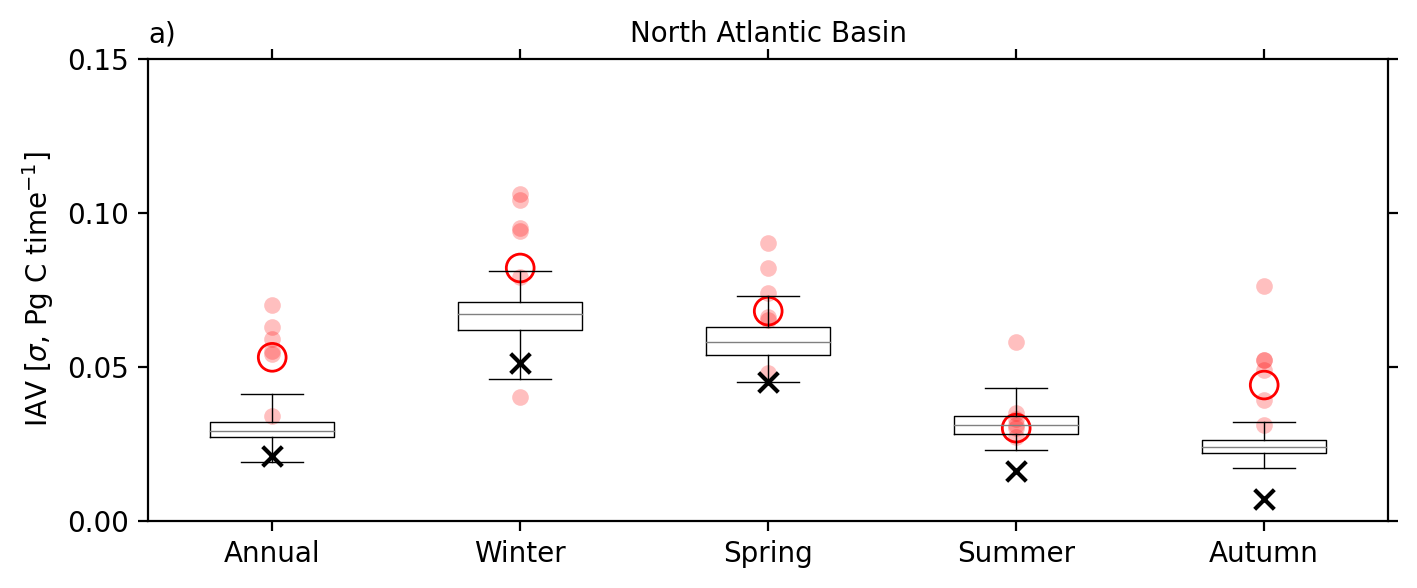

In [4]:
labels=['CMEMS-FFNN','CSIR-ML6','ETH-SOMFFN','Jena-MLS','JMA-MLR','NIES-NN','Multiplatform Mean','MPI-GE Mean']

fig = plt.figure(figsize=(10,8),dpi=600)

box=members.plot(kind='box', color=dict(boxes='black', 
                                        whiskers='black', 
                                        medians='black', 
                                        caps='black'),
                 sym='+',
            boxprops=dict(linestyle='-', 
                          linewidth=0.5),
            # flierprops=dict(linestyle='-', 
            #                 linewidth=0.5),
            medianprops=dict(linestyle='-', 
                             linewidth=0.5, 
                             color='grey'),
            whiskerprops=dict(linestyle='-', 
                              linewidth=0.5),
            capprops=dict(linestyle='-', 
                          linewidth=0.5),
            showfliers=True, 
            figsize=(8,3), 
            whis=2)

# colors = ['#4F008F','#246BFF','#33E4FF','#00A380',"#74FB84", "#F2BC40"]

colors = ['#FF0000','#FF0000','#FF0000','#FF0000',
          '#FF0000','#FF0000','#FF0000','#000000']

for i,c in zip(range(0,len(variability)-2),colors):
    plt.scatter(1,variability[i][0],color=c, alpha=0.25, linewidth=0, label=str(labels[i]))  
    plt.scatter(2,variability[i][1],color=c, alpha=0.25, linewidth=0)  
    plt.scatter(3,variability[i][2],color=c, alpha=0.25, linewidth=0)  
    plt.scatter(4,variability[i][3],color=c, alpha=0.25, linewidth=0)
    plt.scatter(5,variability[i][4],color=c, alpha=0.25, linewidth=0) 
    
plt.scatter(1,variability[6][0], color='red',s=100, facecolor='None', edgecolor='red', label=str(labels[6]), zorder=1)
plt.scatter(2,variability[6][1], color='red',s=100, facecolor='None', edgecolor='red',zorder=1)
plt.scatter(3,variability[6][2], color='red',s=100, facecolor='None', edgecolor='red',zorder=1)
plt.scatter(4,variability[6][3], color='red',s=100, facecolor='None', edgecolor='red',zorder=1)
plt.scatter(5,variability[6][4], color='red',s=100, facecolor='None', edgecolor='red',zorder=1)

plt.scatter(1,variability[7][0],s=50, color="black", marker="x", label=str(labels[7]), zorder=1)
plt.scatter(2,variability[7][1],s=50, color="black", marker="x", zorder=1)
plt.scatter(3,variability[7][2],s=50, color="black", marker="x", zorder=1)
plt.scatter(4,variability[7][3],s=50, color="black", marker="x", zorder=1)
plt.scatter(5,variability[7][4],s=50, color="black", marker="x", zorder=1)

plt.ylim(0,0.1)
plt.yticks([0,0.05,0.1,0.15])

plt.ylabel('IAV [$\sigma$, Pg C time$^{-1}$]', fontsize=10)
plt.title('North Atlantic Basin', fontsize=10)
plt.title("a)", loc='left',fontsize=10)

plt.tick_params(top='off', right='off', which='both') 
# plt.tick_params(axis='both', which='both', length=0)

#plt.text(0.65,0.068,'North Atlantic', fontsize=10)
# plt.legend(scatterpoints=1, ncol=8, fontsize=10, loc=8, bbox_to_anchor=(0.5, -0.5),fancybox=True, shadow=True) 

plt.savefig('2023_Fig3Panela_1990_2020_MPI.svg', format="svg",transparent=True)

### Southern Ocean

In [5]:
observations=['lsce','csir','spco2','jena','jma','nies','ens']
f_ens = xr.open_dataset('/work/uo1075/from_Mistral/uo1075/u301331/observations/ens_1990-2020_co2.nc')
f_ens_time = f_ens.time

variability_so=np.zeros((8,5))

for i in range(0,len(observations)):
    f = '{}{}{}'.format('/work/uo1075/from_Mistral/uo1075/u301331/observations/',observations[i],'_1990-2020_co2.nc')
    # print(f)
    f1 = xr.open_dataset(f, decode_times=False)
    if (i == 3):
        f1= f1.rename({'mtime': 'time'})
    f1['time'] = f_ens_time
    
    f2 = f1.co2flux.sel(lon=slice(-180,180),lat=slice(-65,-35)).sel(time=slice('1990','2019'))
    variability_so[i,0] =((f2.groupby('time.year').mean('time')).sum(('lon','lat')).std().values.round(3))
    variability_so[i,1] =(f2.sel(time=f2.time.dt.season=="DJF").groupby('time.year').mean('time').sum(('lon','lat')).std().values.round(3))
    variability_so[i,2] =(f2.sel(time=f2.time.dt.season=="MAM").groupby('time.year').mean('time').sum(('lon','lat')).std().values.round(3))
    variability_so[i,3] =(f2.sel(time=f2.time.dt.season=="JJA").groupby('time.year').mean('time').sum(('lon','lat')).std().values.round(3))
    variability_so[i,4] =(f2.sel(time=f2.time.dt.season=="SON").groupby('time.year').mean('time').sum(('lon','lat')).std().values.round(3))
    
f1 = xr.open_dataset('/work/uo1075/from_Mistral/uo1075/u301331/observations/mpi_1990-2020_co2.nc', decode_times=False)
f1['time'] = f_ens_time

f2 = f1.co2flux.sel(depth=0).sel(lon=slice(0,360),lat=slice(-65,-35)).sel(time=slice('1990','2005'))
variability_so[7,0] =((f2.groupby('time.year').mean('time')).sum(('lon','lat')).std().values.round(3))
variability_so[7,1] =(f2.sel(time=f2.time.dt.season=="DJF").groupby('time.year').mean('time').sum(('lon','lat')).std().values.round(3))
variability_so[7,2] =(f2.sel(time=f2.time.dt.season=="MAM").groupby('time.year').mean('time').sum(('lon','lat')).std().values.round(3))
variability_so[7,3] =(f2.sel(time=f2.time.dt.season=="JJA").groupby('time.year').mean('time').sum(('lon','lat')).std().values.round(3))
variability_so[7,4] =(f2.sel(time=f2.time.dt.season=="SON").groupby('time.year').mean('time').sum(('lon','lat')).std().values.round(3))

# Make DataFrame
annual_ob_so=[]
winter_ob_so=[]
spring_ob_so=[]
summer_ob_so=[]
autumn_ob_so=[]

for i in range(0,7):
    annual_ob_so.append(variability_so[i][0])
    winter_ob_so.append(variability_so[i][1])
    spring_ob_so.append(variability_so[i][2])
    summer_ob_so.append(variability_so[i][3])
    autumn_ob_so.append(variability_so[i][4])
    
observations=pd.DataFrame(list(zip(annual_ob_so, winter_ob_so, spring_ob_so, summer_ob_so, autumn_ob_so)),
                     columns =['Annual Mean', 'Winter', 'Spring', 'Summer','Autumn'])

In [6]:
variability_ge_so=np.zeros((100,5))
for i in range(1,101):
    f='{}{}{}'.format('/work/uo1075/from_Mistral/uo1075/u301331/model_GE_co2/GE_co2_',i,'.nc')
    # print(f)
    f1 = xr.open_dataset(f)
    
    f2 = f1.co2flux.sel(depth=0).sel(lon=slice(0,360),lat=slice(-65,-35)).sel(time=slice('1990','2019'))
    variability_ge_so[i-1,0] =((f2.groupby('time.year').mean('time')).sum(('lon','lat')).std().values.round(3))
    variability_ge_so[i-1,1] =(f2.sel(time=f2.time.dt.season=="DJF").groupby('time.year').mean('time').sum(('lon','lat')).std().values.round(3))
    variability_ge_so[i-1,2] =(f2.sel(time=f2.time.dt.season=="MAM").groupby('time.year').mean('time').sum(('lon','lat')).std().values.round(3))
    variability_ge_so[i-1,3] =(f2.sel(time=f2.time.dt.season=="JJA").groupby('time.year').mean('time').sum(('lon','lat')).std().values.round(3))
    variability_ge_so[i-1,4] =(f2.sel(time=f2.time.dt.season=="SON").groupby('time.year').mean('time').sum(('lon','lat')).std().values.round(3))
   
# Make DataFrame
annual_ge_so=[]
winter_ge_so=[]
spring_ge_so=[]
summer_ge_so=[]
autumn_ge_so=[]

for i in range(0,100):
    annual_ge_so.append(variability_ge_so[i][0])
    winter_ge_so.append(variability_ge_so[i][1])
    spring_ge_so.append(variability_ge_so[i][2])
    summer_ge_so.append(variability_ge_so[i][3])
    autumn_ge_so.append(variability_ge_so[i][4])
    
members_so=pd.DataFrame(list(zip(annual_ge_so, winter_ge_so, spring_ge_so, summer_ge_so, autumn_ge_so)),
                     columns =['Annual', 'Winter', 'Spring', 'Summer','Autumn'])

## Figure

<Figure size 6000x4800 with 0 Axes>

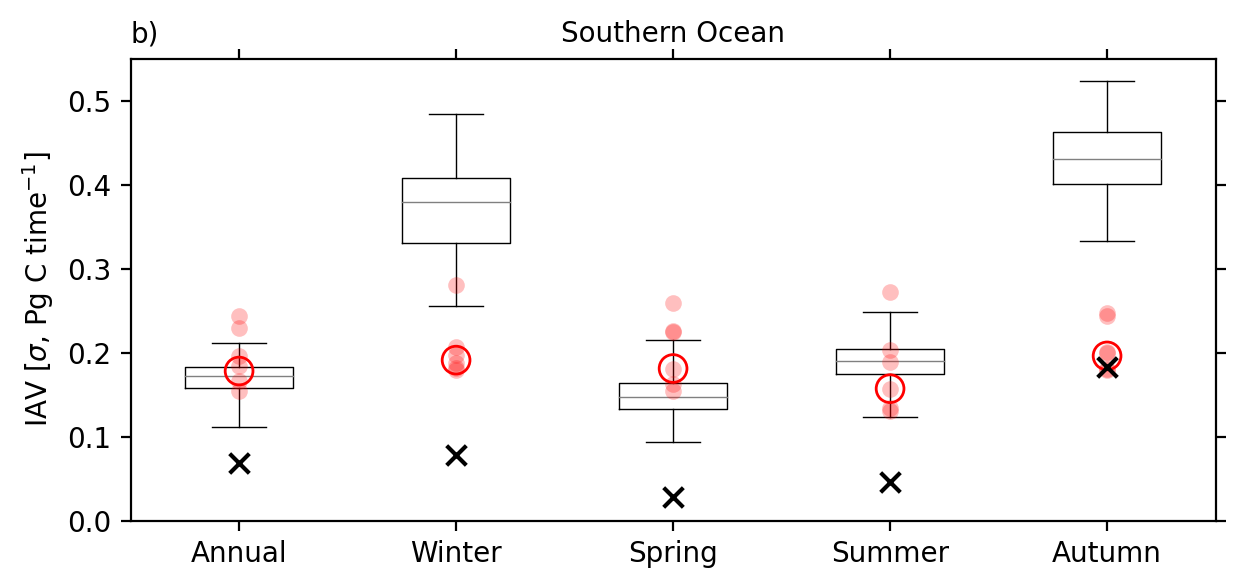

In [8]:
fig = plt.figure(figsize=(10,8),dpi=600)

box=members_so.plot(kind='box', color=dict(boxes='black', whiskers='black', medians='black', caps='black'),
            boxprops=dict(linestyle='-', linewidth=0.5),
            flierprops=dict(linestyle='-', linewidth=0.5),
            medianprops=dict(linestyle='-', linewidth=0.5, color='grey'),
            whiskerprops=dict(linestyle='-', linewidth=0.5),
            capprops=dict(linestyle='-', linewidth=0.5),
            showfliers=True, grid=False, rot=0, figsize=(7,3), whis=2, sym='.', zorder=0)

for i,c in zip(range(0,len(variability)-2),colors):
    plt.scatter(1,variability_so[i][0],color=c, alpha=0.25, linewidth=0, label=str(labels[i]))  
    plt.scatter(2,variability_so[i][1],color=c, alpha=0.25, linewidth=0)  
    plt.scatter(3,variability_so[i][2],color=c, alpha=0.25, linewidth=0)  
    plt.scatter(4,variability_so[i][3],color=c, alpha=0.25, linewidth=0)
    plt.scatter(5,variability_so[i][4],color=c, alpha=0.25, linewidth=0) 
    
plt.scatter(1,variability_so[6][0], color='red',s=100, facecolor='None', edgecolor='red',label=str(labels[6]), zorder=1)
plt.scatter(2,variability_so[6][1], color='red',s=100, facecolor='None', edgecolor='red',zorder=1)
plt.scatter(3,variability_so[6][2], color='red',s=100, facecolor='None', edgecolor='red',zorder=1)
plt.scatter(4,variability_so[6][3], color='red',s=100, facecolor='None', edgecolor='red',zorder=1)
plt.scatter(5,variability_so[6][4], color='red',s=100, facecolor='None', edgecolor='red',zorder=1)

plt.scatter(1,variability_so[7][0],s=50, color="black", marker="x", label=str(labels[7]), zorder=1)
plt.scatter(2,variability_so[7][1],s=50, color="black", marker="x", zorder=1)
plt.scatter(3,variability_so[7][2],s=50, color="black", marker="x", zorder=1)
plt.scatter(4,variability_so[7][3],s=50, color="black", marker="x", zorder=1)
plt.scatter(5,variability_so[7][4],s=50, color="black", marker="x", zorder=1)

plt.ylim(0,0.55)
plt.yticks([0,0.1, 0.2, 0.3, 0.4,0.5])

plt.ylabel('IAV [$\sigma$, Pg C time$^{-1}$]', fontsize=10)
plt.title('Southern Ocean', fontsize=10)
plt.title("b)", loc='left',fontsize=10)

plt.tick_params(top='off', right='off', which='both') 
# plt.tick_params(axis='both', which='both', length=0.1)

#plt.text(0.65,0.068,'North Atlantic', fontsize=10)

# plt.legend(scatterpoints=1, ncol=8, fontsize=10, loc=8, bbox_to_anchor=(0.5, -0.5),fancybox=True, shadow=True) 

plt.savefig('2023_Fig3Panelb_1990_2020_MPI.svg', format="svg",transparent=True)